# Floor Mesh Pipeline (Cleaned)

This notebook performs:

1. Segment the floor with SAM2 and pick the best mask via CLIP("floor").
2. Back-project floor contour pixels to world frame using intrinsics + camera extrinsics.
3. Build a 2D floor polygon (XY), fix/simplify it, and triangulate with a target max area.
4. Prune tiny triangles, compute centroids, and visualize in world (overhead) frame.
5. Fit a ground plane, lift vertices to 3D, transform to camera, and project to image.
6. Overlay the pruned mesh and labels on the camera image.
7. Build a triangle adjacency graph (by shared edges), optionally bridge components safely inside the floor polygon, and visualize the graph on the image.

Tune: `max_area` (triangle size), `min_area_world` (pruning), and `polygon.simplify(tolerance=...)` for stability.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.transform import Rotation as R

from sam2.build_sam import build_sam2 # type: ignore
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator # type: ignore

import clip # type: ignore
import cv2

class Vector3D:
    def __init__(self, x: float, y: float, z: float, x_axis: float, y_axis: float, z_axis: float, rotation: float):
        self.x = x
        self.y = y
        self.z = z
        self.x_axis = x_axis
        self.y_axis = y_axis
        self.z_axis = z_axis
        self.rotation = rotation

    def __repr__(self):
        return f"Vector3D({self.x}, {self.y}, {self.z}, {self.x_axis}, {self.y_axis}, {self.z_axis}, {self.rotation})"

pib_pos = Vector3D(3.3786, 3.29366, 1.89995, 0.13050301753046564, 0.01717530230715774, -0.9912991331611769, 2.88204)

fx = 686.9927350716014
fy = 686.9927350716014
cx = 640.0
cy = 360.0

In [2]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

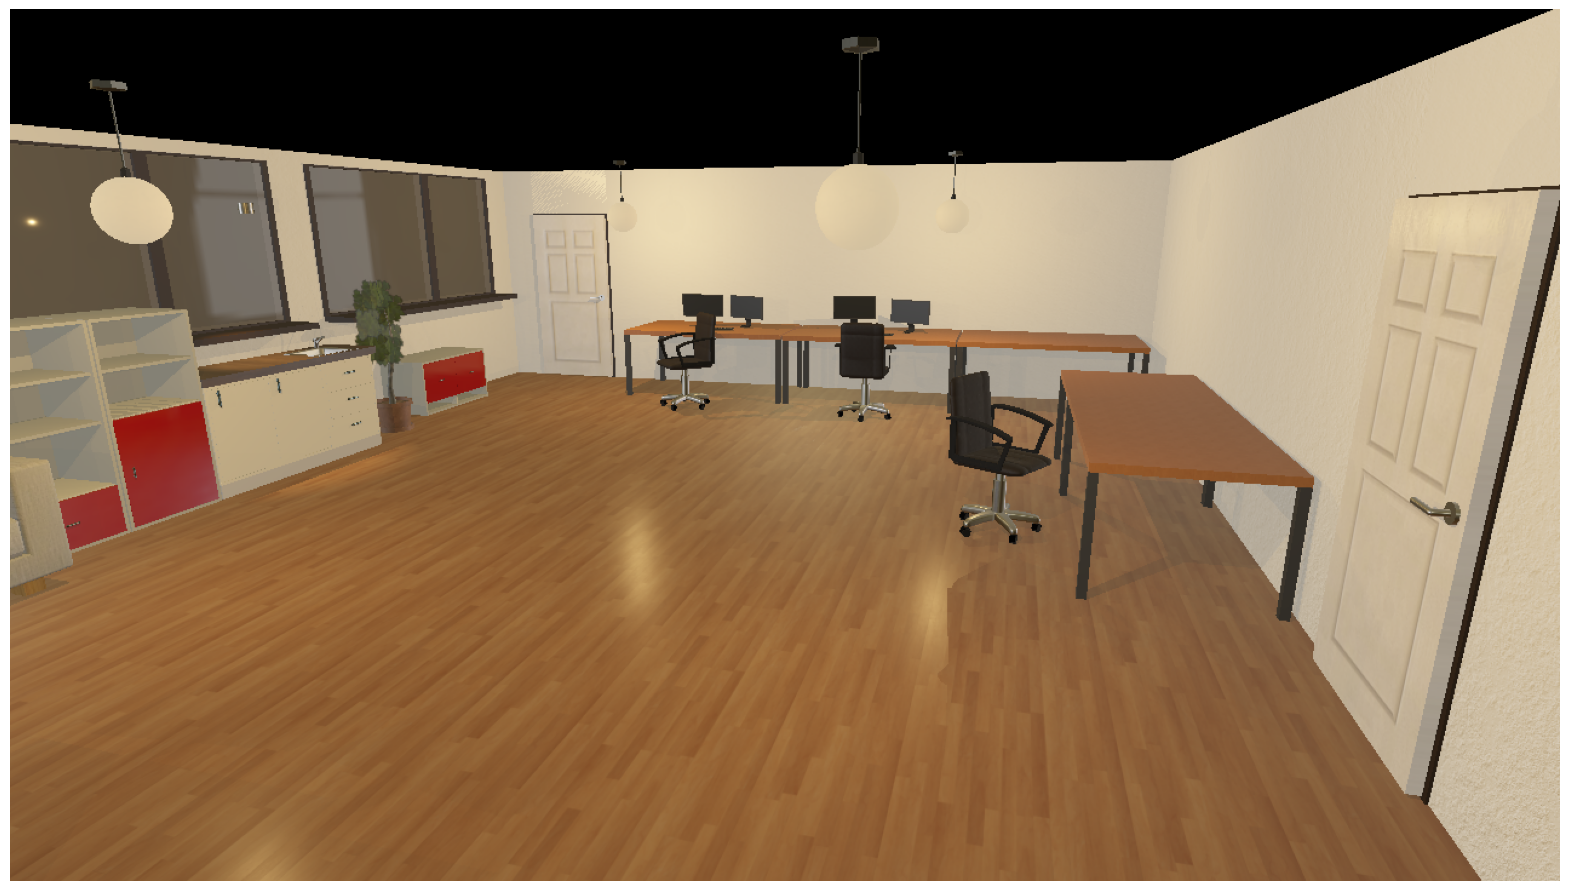

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


image = Image.open('segment_test.png')
image = np.array(image.convert("RGB"))



plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


In [4]:
sam2_checkpoint = "/home/mahdlinux/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)
masks = mask_generator.generate(image)

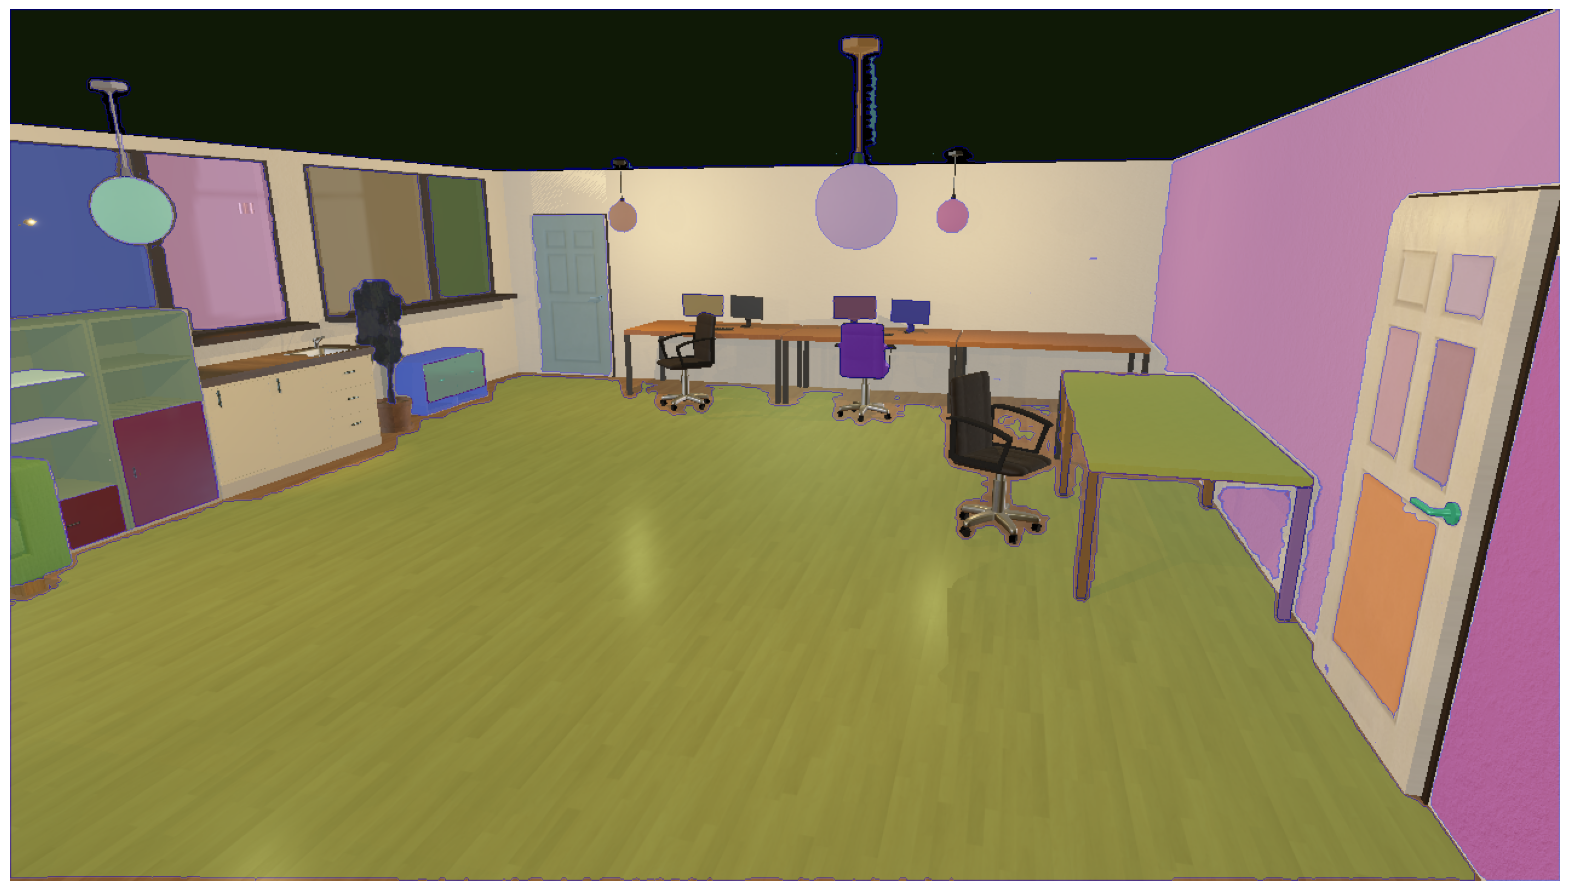

In [5]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [6]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
text = clip.tokenize(["floor"]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text)

In [7]:
# Encode text prompt
text = clip.tokenize(["floor"]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text)

In [8]:
best_score = -1.0
best_mask = None

image_rgb = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB) if image.shape[-1] == 4 else image.copy()

for mi in masks:
    m = mi["segmentation"].astype(np.uint8)
    x, y, w, h = map(int, mi["bbox"])  # crop to bbox
    cropped = cv2.bitwise_and(image_rgb, image_rgb, mask=m)[y:y+h, x:x+w]
    if cropped.size == 0:
        continue
    pil = Image.fromarray(cropped)
    image_input = clip_preprocess(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        img_feat = clip_model.encode_image(image_input)
    sim = (img_feat @ text_features.T).item()
    if sim > best_score:
        best_score = sim
        best_mask = m

print(f"Best matching mask score: {best_score:.4f}")

Best matching mask score: 36.7672


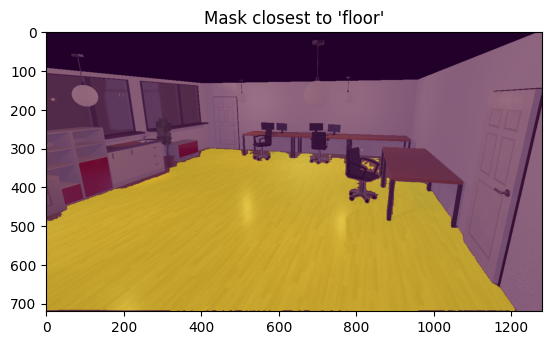

In [9]:
np.save('best_mask.npy', best_mask)

plt.imshow(image_rgb)
plt.imshow(best_mask, alpha=0.5)
plt.title("Mask closest to 'floor'")
plt.show()

In [10]:
# best_mask: binary mask from SAM+CLIP
contours, _ = cv2.findContours(best_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Usually there is only 1 large contour, but you can pick the biggest
floor_contour = max(contours, key=cv2.contourArea)

In [ ]:
depth_array = np.load('test_depth.npy')
depth_array

array([[      inf,       inf,       inf, ..., 2.3960001, 2.411    ,
        2.38     ],
       [      inf,       inf,       inf, ..., 2.42     , 2.403    ,
        2.4050002],
       [      inf,       inf,       inf, ..., 2.403    , 2.414    ,
        2.411    ],
       ...,
       [2.483    , 2.4910002, 2.492    , ..., 2.1560001, 2.148    ,
        2.161    ],
       [2.489    , 2.4870002, 2.4910002, ..., 2.148    , 2.17     ,
        2.171    ],
       [2.48     , 2.489    , 2.483    , ..., 2.1820002, 2.17     ,
        2.1520002]], dtype=float32)

In [12]:
mask_world_points = []
for u, v in floor_contour[:, 0, :]:
    depth = depth_array[v, u]
    if np.isnan(depth) or depth <= 0 or depth > 10:
        depth = 10.0
    # Camera coordinates (same as before)
    X_cam = depth
    Y_cam = -(u - cx) * depth / fx
    Z_cam = -(v - cy) * depth / fy
    P_camera = np.array([X_cam, Y_cam, Z_cam])
    # Rotation and translation (same as before)
    axis = np.array([pib_pos.x_axis, pib_pos.y_axis, pib_pos.z_axis])
    angle = pib_pos.rotation
    r = R.from_rotvec(axis * angle)
    R_matrix = r.as_matrix()
    T = np.array([pib_pos.x, pib_pos.y, pib_pos.z])
    # World coordinates
    P_world = R_matrix @ P_camera + T
    mask_world_points.append(P_world)
mask_world_points = np.array(mask_world_points)

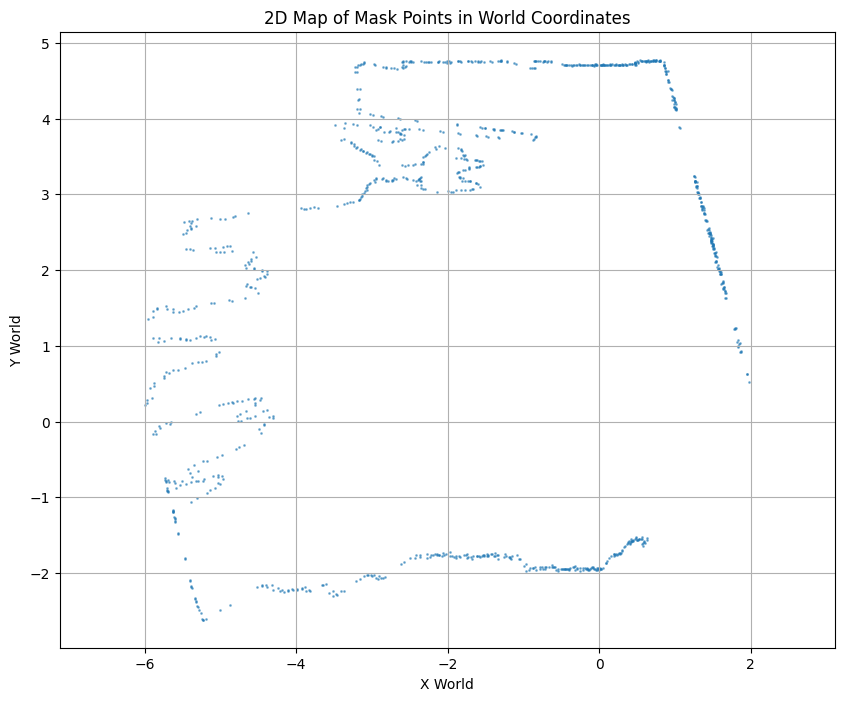

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(mask_world_points[:, 0], mask_world_points[:, 1], s=1, alpha=0.5)
plt.xlabel('X World')
plt.ylabel('Y World')
plt.title('2D Map of Mask Points in World Coordinates')
plt.axis('equal')
plt.grid(True)
plt.show()

In [14]:
from shapely.geometry import Polygon

polygon = Polygon(mask_world_points[:, :2])  # Use only X and Y for 2D polygon

if not polygon.is_valid:
    print("Polygon is invalid, attempting to fix...")
    polygon = polygon.buffer(0)  # Attempt to fix invalid polygon by buffering with 0 distance

Polygon is invalid, attempting to fix...


In [15]:
import triangle

polygon = polygon.simplify(tolerance=0.06, preserve_topology=True)
coords = np.array(polygon.exterior.coords)

tri_in = {
    'vertices': coords,
    'segments': [[i, (i + 1) % len(coords)] for i in range(len(coords))],
}

max_area = 1.2
t = triangle.triangulate(tri_in, f'pqa{max_area}')

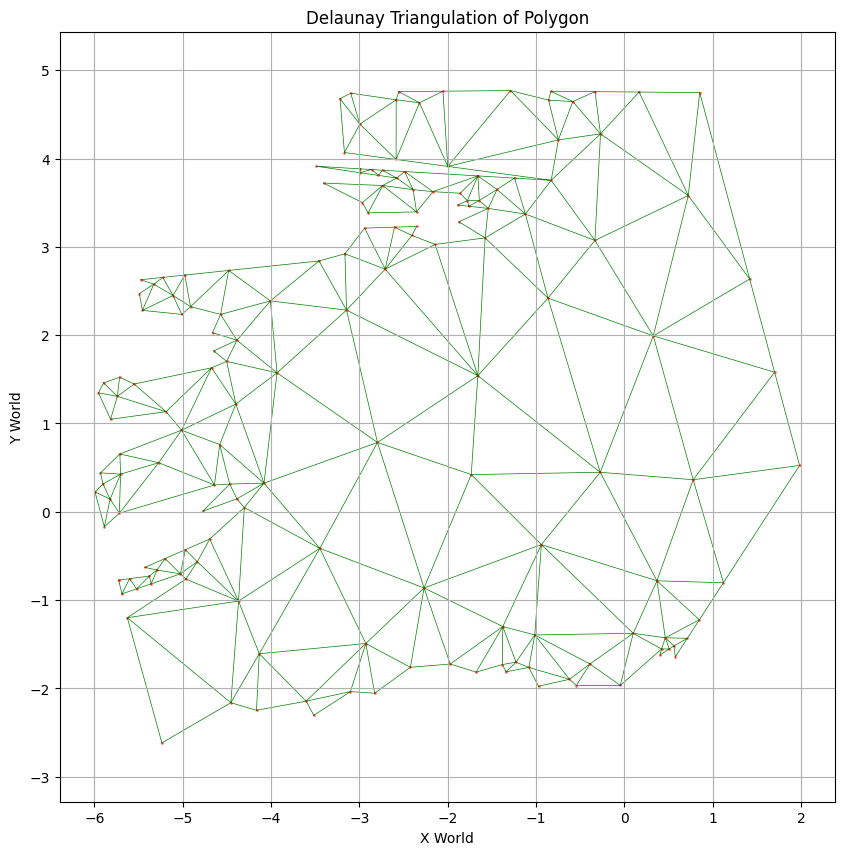

In [16]:
# Visualize the triangulation
plt.figure(figsize=(10, 10))
plt.triplot(t['vertices'][:, 0], t['vertices'][:, 1], t['triangles'], color='green', lw=0.5)
plt.scatter(t['vertices'][:, 0], t['vertices'][:, 1], s=1, alpha=0.5, color='red')
plt.xlabel('X World')
plt.ylabel('Y World')
plt.title('Delaunay Triangulation of Polygon')
plt.axis('equal')
plt.grid(True)
plt.show()

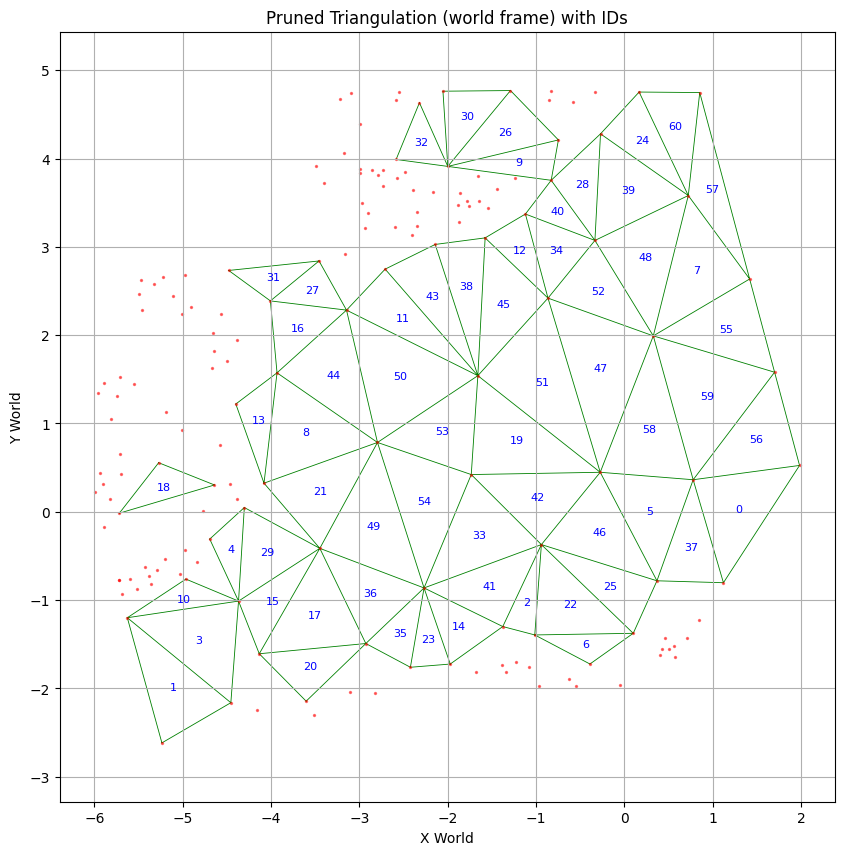

In [17]:
# Prune tiny triangles and label
verts = t['vertices']
tris = t['triangles']

areas = []
for i0, i1, i2 in tris:
    p0, p1, p2 = verts[i0], verts[i1], verts[i2]
    areas.append(0.5 * abs((p1[0] - p0[0]) * (p2[1] - p0[1]) - (p1[1] - p0[1]) * (p2[0] - p0[0])))
areas = np.asarray(areas)

min_area_world = 0.15 * max_area
keep_mask = areas >= min_area_world
triangles_kept = tris[keep_mask]
triangle_ids = np.arange(len(triangles_kept))
centroids_world_xy = verts[triangles_kept].mean(axis=1)

plt.figure(figsize=(10, 10))
plt.triplot(verts[:, 0], verts[:, 1], triangles_kept, color='green', lw=0.6)
plt.scatter(verts[:, 0], verts[:, 1], s=2, alpha=0.5, color='red')
for i, c in enumerate(centroids_world_xy):
    plt.text(c[0], c[1], str(triangle_ids[i]), color='blue', fontsize=8, ha='center', va='center')
plt.xlabel('X World')
plt.ylabel('Y World')
plt.title('Pruned Triangulation (world frame) with IDs')
plt.axis('equal')
plt.grid(True)
plt.show()

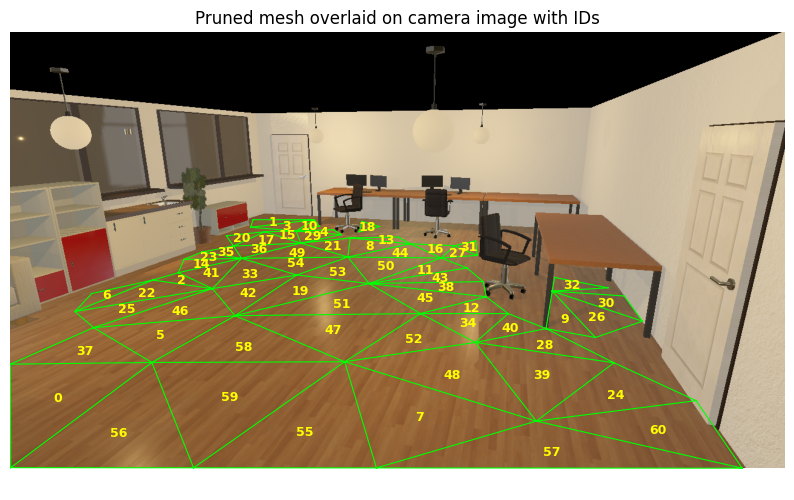

In [18]:
# Fit a ground plane z = a*x + b*y + c from the mask_world_points (3D in world frame)
Xw = mask_world_points[:, 0]
Yw = mask_world_points[:, 1]
Zw = mask_world_points[:, 2]
G = np.c_[Xw, Yw, np.ones_like(Xw)]
(a, b, c), *_ = np.linalg.lstsq(G, Zw, rcond=None)

# Lift 2D mesh vertices (world XY) onto the plane to get 3D world points
mesh_world_xy = t['vertices']                      # shape (N, 2)
mesh_world_z = a * mesh_world_xy[:, 0] + b * mesh_world_xy[:, 1] + c
mesh_world_3d = np.column_stack([mesh_world_xy, mesh_world_z])

# Compute inverse extrinsics: world -> camera
axis = np.array([pib_pos.x_axis, pib_pos.y_axis, pib_pos.z_axis])
angle = pib_pos.rotation
R_cw = R.from_rotvec(axis * angle).as_matrix()     # camera -> world
R_wc = R_cw.T                                      # world -> camera
T = np.array([pib_pos.x, pib_pos.y, pib_pos.z])    # world translation of camera origin

# Transform mesh vertices to camera frame
mesh_cam = (R_wc @ (mesh_world_3d - T).T).T        # shape (N, 3)
Xc = mesh_cam[:, 0]
Yc = mesh_cam[:, 1]
Zc = mesh_cam[:, 2]

# Project to pixels (your convention uses X as forward axis)
u = cx - fx * (Yc / Xc)
v = cy - fy * (Zc / Xc)

# Keep triangles fully in front of the camera and with finite pixels
valid_vertex = (Xc > 1e-6) & np.isfinite(u) & np.isfinite(v)

# Use pruned triangles if available, else fallback to all
if 'triangles_kept' in locals() and 'triangle_ids' in locals():
    triangles_base = triangles_kept
    ids_base = triangle_ids
else:
    triangles_base = t['triangles']
    ids_base = np.arange(len(triangles_base))

tri_mask = np.all(valid_vertex[triangles_base], axis=1)
triangles_proj = triangles_base[tri_mask]
ids_proj = ids_base[tri_mask]

# Overlay on the original image with triangle IDs at image-space centroids
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
if len(triangles_proj) > 0:
    plt.triplot(u, v, triangles_proj, color='lime', lw=0.8)
    centroids_img = np.stack([u, v], axis=1)[triangles_proj].mean(axis=1)
    for i, cid in enumerate(ids_proj):
        x, y = centroids_img[i]
        plt.text(x, y, str(cid), color='yellow', fontsize=9, ha='center', va='center', fontweight='bold')
plt.title('Pruned mesh overlaid on camera image with IDs')
plt.axis('off')
plt.show()

In [19]:
class Node:
    def __init__(self, id, image_point, world_point):
        self.id = id
        self.image_point = image_point
        self.world_point = world_point
        self.edges = set()

    def add_edge(self, other_node):
        self.edges.add(other_node)
    
    def __repr__(self):
        return f"Node(id={self.id}, image_point={self.image_point}, world_point={self.world_point}, edges={[n.id for n in self.edges]})"

In [20]:
# Build adjacency list from pruned mesh via shared edges (efficient)
verts = t['vertices']
tris_kept = triangles_kept
ids = triangle_ids

# Image-space centroids for each kept triangle (NaN if any vertex invalid)
pts_img = np.stack([u, v], axis=1)
valid_tri = np.all(valid_vertex[tris_kept], axis=1)
centroids_img = np.full((len(tris_kept), 2), np.nan, dtype=float)
centroids_img[valid_tri] = pts_img[tris_kept[valid_tri]].mean(axis=1)
centroids_world = centroids_world_xy

adjacency_list = {int(ids[i]): Node(int(ids[i]), image_point=centroids_img[i], world_point=centroids_world[i])
                  for i in range(len(tris_kept))}

edge_owner = {}
for i, tri in enumerate(tris_kept):
    tid = int(ids[i])
    a, b, c = map(int, tri)
    edges = [(min(a, b), max(a, b)), (min(b, c), max(b, c)), (min(c, a), max(c, a))]
    for e in edges:
        if e in edge_owner:
            other_tid = edge_owner[e]
            adjacency_list[tid].add_edge(adjacency_list[other_tid])
            adjacency_list[other_tid].add_edge(adjacency_list[tid])
        else:
            edge_owner[e] = tid

print(f"Kept triangles: {len(tris_kept)}")
first_keys = sorted(adjacency_list.keys())[:5]
for k in first_keys:
    print(f"Triangle {k} neighbors: {[n.id for n in sorted(adjacency_list[k].edges, key=lambda x: x.id)]}")

Kept triangles: 61
Triangle 0 neighbors: [37, 56]
Triangle 1 neighbors: [3]
Triangle 2 neighbors: [22, 41]
Triangle 3 neighbors: [1, 10]
Triangle 4 neighbors: [29]


In [21]:
def connected_components(adj):
    visited, comps = set(), []
    for nid in adj.keys():
        if nid in visited:
            continue
        stack = [nid]
        comp = []
        visited.add(nid)
        while stack:
            cur = stack.pop()
            comp.append(cur)
            for nb in adj[cur].edges:
                if nb.id not in visited:
                    visited.add(nb.id)
                    stack.append(nb.id)
        comps.append(sorted(comp))
    return comps

In [22]:
from shapely.geometry import LineString

# centroids_world_xy is (Nk,2) aligned with triangle_ids = np.arange(Nk)
# adjacency_list keys are the same ids
def bridge_components(adjacency_list, centroids_world_xy, polygon, margin=1e-3):
    comps = connected_components(adjacency_list)
    print(f"Components before bridging: {len(comps)} -> sizes {[len(c) for c in comps]}")
    if len(comps) <= 1:
        return

    # Erode polygon slightly to keep bridges strictly inside
    safe_poly = polygon.buffer(-margin)

    while len(comps) > 1:
        best = None  # (dist2, a_id, b_id)
        A, B = comps[0], comps[1]

        # Search for the shortest valid in-polygon bridge between first two components
        for a_id in A:
            pa = centroids_world_xy[a_id]
            for b_id in B:
                pb = centroids_world_xy[b_id]
                seg = LineString([tuple(pa), tuple(pb)])
                if safe_poly.covers(seg):  # stays inside polygon
                    d2 = np.sum((pa - pb) ** 2)
                    if best is None or d2 < best[0]:
                        best = (d2, a_id, b_id)

        if best is None:
            # Relax: allow touching boundary if strictly inside failed
            for a_id in A:
                pa = centroids_world_xy[a_id]
                for b_id in B:
                    pb = centroids_world_xy[b_id]
                    seg = LineString([tuple(pa), tuple(pb)])
                    if polygon.covers(seg):
                        d2 = np.sum((pa - pb) ** 2)
                        if best is None or d2 < best[0]:
                            best = (d2, a_id, b_id)

        if best is None:
            print("No valid in-polygon bridge found; consider lowering pruning or increasing max_area.")
            break

        _, a_id, b_id = best
        # Add undirected graph edge
        adjacency_list[a_id].add_edge(adjacency_list[b_id])
        adjacency_list[b_id].add_edge(adjacency_list[a_id])

        # Recompute components
        comps = connected_components(adjacency_list)

    print(f"Components after bridging: {len(comps)} -> sizes {[len(c) for c in comps]}")

In [23]:
# run the bridging
bridge_components(adjacency_list, centroids_world_xy, polygon, margin=0.01)

Components before bridging: 5 -> sizes [53, 3, 3, 1, 1]
Components after bridging: 1 -> sizes [61]


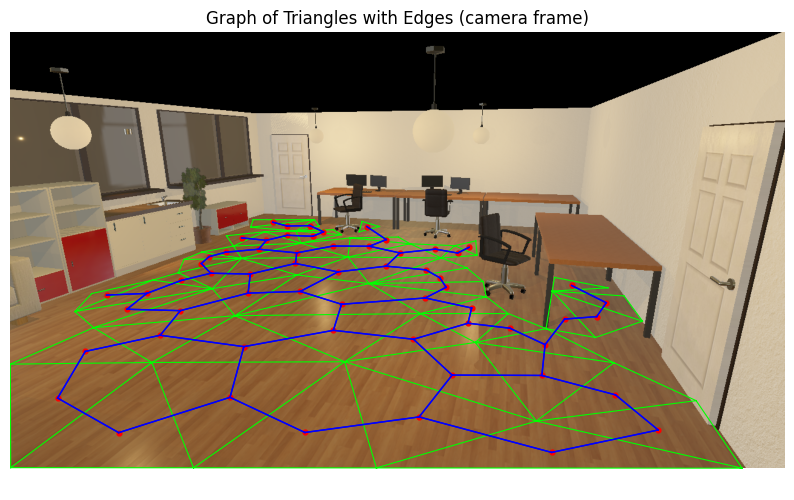

In [24]:
# Visualize graph over mesh on camera image (skip NaNs)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
if len(triangles_proj) > 0:
    plt.triplot(u, v, triangles_proj, color='lime', lw=0.8)
for node in adjacency_list.values():
    p = node.image_point
    if np.any(np.isnan(p)):
        continue
    plt.scatter(p[0], p[1], color='red', s=12)
    for nb in node.edges:
        q = nb.image_point
        if np.any(np.isnan(q)):
            continue
        plt.plot([p[0], q[0]], [p[1], q[1]], 'b-', lw=1)
plt.title('Graph of Triangles with Edges (camera frame)')
plt.axis('off')
plt.show()